<a href="https://colab.research.google.com/github/ZeynelAbidin91/DL-in-Computer-vision/blob/master/brain_tumor_detection_with_pretrained_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a id='env'>1. Dowloading Kaggle Dataset</a>

In [1]:
! pip install -q kaggle 

In [ ]:
from google.colab import files

files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection --force

 53% 8.00M/15.1M [00:00<00:00, 83.3MB/s]
100% 15.1M/15.1M [00:00<00:00, 73.7MB/s]


In [ ]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

# <a id='env'>2. Setting up the Environment</a>

In [8]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [39]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [17]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── brain_tumor_dataset
│   ├── no
│   └── yes
├── no
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── VAL
│   ├── NO
│   └── YES
└── yes

15 directories


In [15]:
IMG_PATH = '/content/brain_tumor_dataset/'
for Class in os.listdir(IMG_PATH):
    print(Class)

yes
no


In [18]:
IMG_PATH = '/content/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

# <a id='import'>3. Data Import and Preprocessing</a>

In [19]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.49it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 2/2 [00:00<00:00, 14.97it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


Let's take a look at the distribution of classes among sets:

In [21]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [22]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

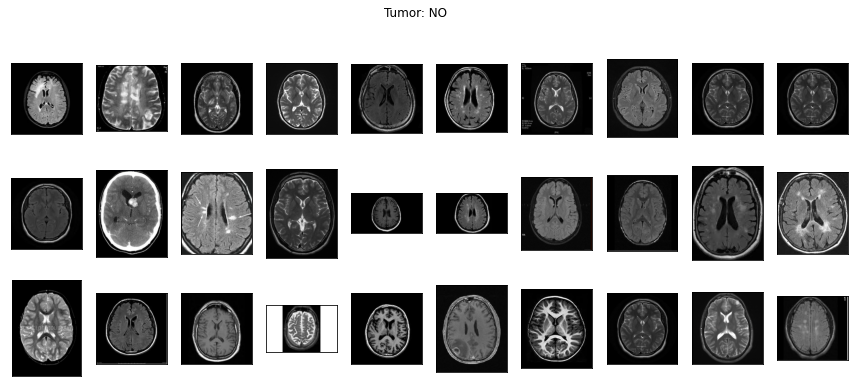

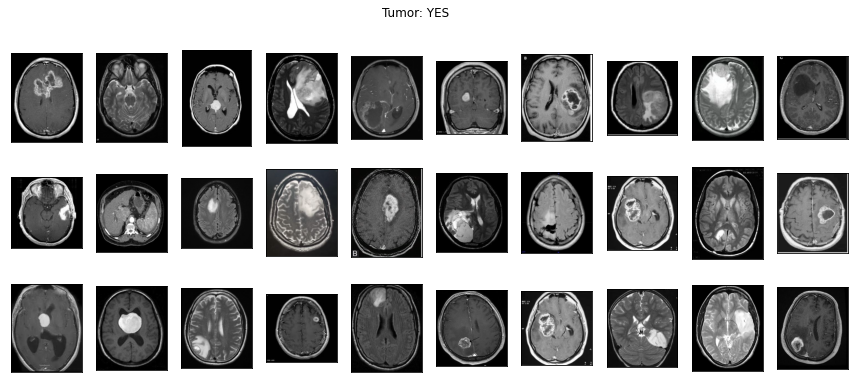

In [23]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

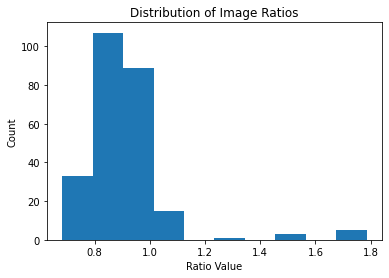

In [24]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [25]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:

In [26]:
img = cv2.imread('/content/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

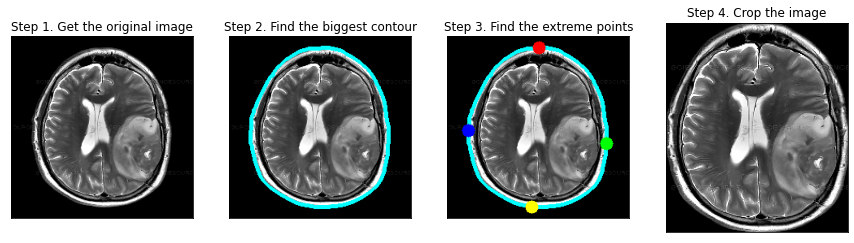

In [27]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [28]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



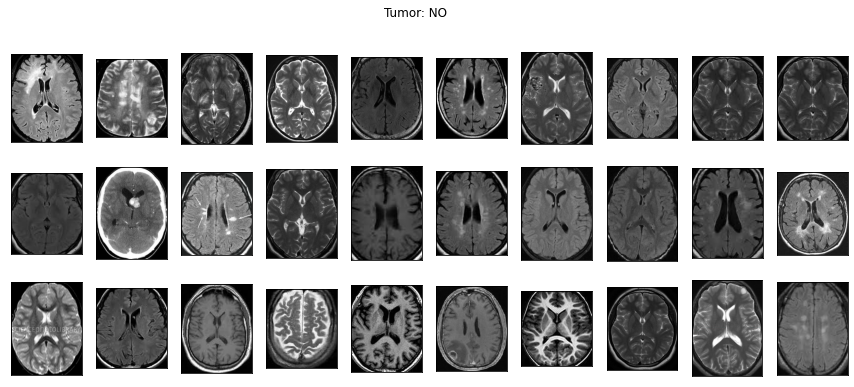

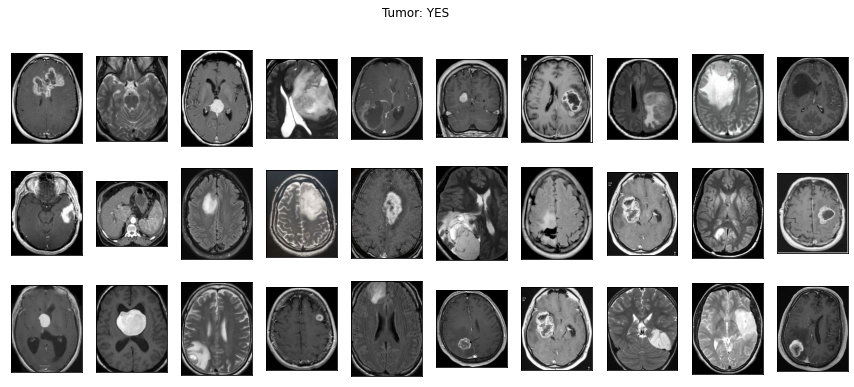

In [29]:
plot_samples(X_train_crop, y_train, labels, 30)

In [30]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [31]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [32]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [33]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [34]:
# plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [35]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [36]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

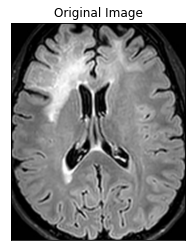

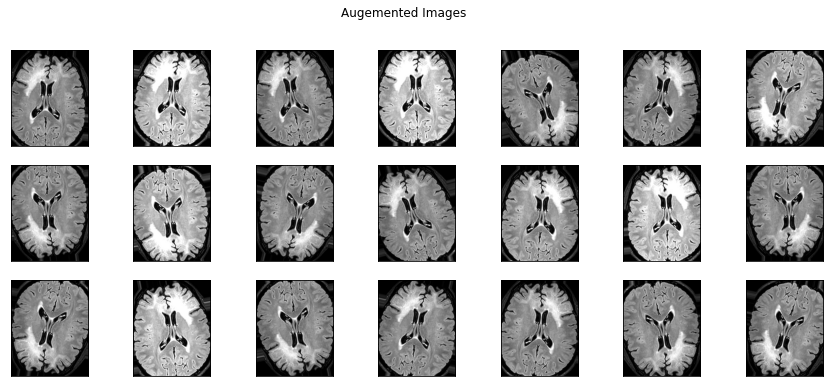

In [37]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [38]:
!rm -rf preview/

### <a id='apply'>4.1.2. Apply</a>

In [43]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [ ]:
# load base model
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
NUM_CLASSES = 1

model_vgg = Sequential()
model_vgg.add(base_model_vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dropout(0.5))
model_vgg.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_vgg.layers[0].trainable = False

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [45]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history_vgg = model_vgg.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

NameError: ignored

## <a id='perf'>4.3. Model Performance</a>

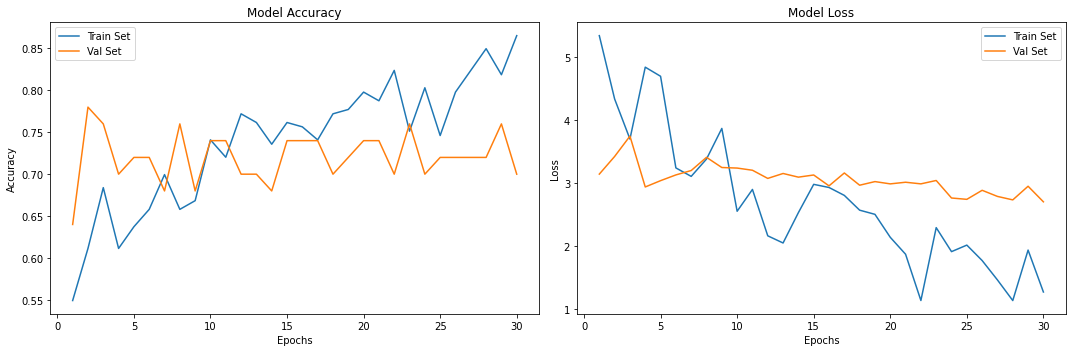

In [ ]:
# plot model performance
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs_range = range(1, len(history_vgg.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.80


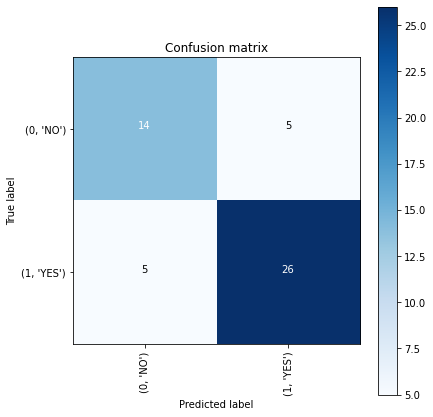

In [ ]:
# validate on val set
predictions = model_vgg.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.90


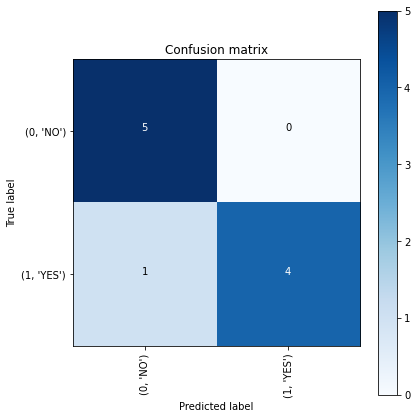

In [ ]:
# validate on test set
predictions = model_vgg.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

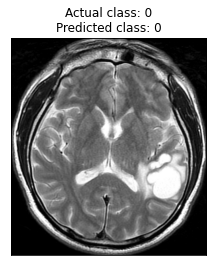

In [ ]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i]Hei,

Hienoa, että teit tilauksesi meiltä! Olemme vastaanottaneet tilauksesi ja laittaneet rattaat pyörimään varastollamme. Saat vielä tekstiviestin tai puhelun, kun tilaus on kerätty noutovalmiiksi valitsemassasi myymälässä ja pidämme varausta vuorokauden. Haluamme, että olet tyytyväinen ostokseesi sekä asiointiisi meillä. Tiesithän, että tarjoamme sinulle lukuisia etuja sekä kattavat asennuspalvelut. Ja hei, muistathan että voit tuoda vanhat laitteesi ilmaiseksi kierrätykseen mihin tahansa Gigantin myymälään!
Vastaanotimme tilauksesi: 31-tammi-2021.
Voit seurata tilauksesi etenemistä kirjautumalla käyttäjätilillesi sivuillamme.)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

First scan looks a bit misleading - what is that light spot in the middle? 🤔 I can clearly see why model classified it as `Tumor`.

# <a id='concl'>5. Applying **Densenet201**</a>



In [ ]:
# load base model
base_model_dense = DenseNet201(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
NUM_CLASSES = 1

model_dense = Sequential()
model_dense.add(base_model_dense)
model_dense.add(layers.Flatten())
model_dense.add(layers.Dropout(0.5))
model_dense.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_dense.layers[0].trainable = False

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 94080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 94081     
Total params: 18,416,065
Trainable params: 94,081
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
history_dense = model_dense.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
7/7 [==============================] - 18s 1s/step - loss: 5.5458 - accuracy: 0.5446 - val_loss: 2.0766 - val_accuracy: 0.7000
Epoch 2/30
7/7 [==============================] - 3s 545ms/step - loss: 3.3509 - accuracy: 0.6453 - val_loss: 4.3985 - val_accuracy: 0.6200
Epoch 3/30
7/7 [==============================] - 3s 545ms/step - loss: 4.4129 - accuracy: 0.4871 - val_loss: 1.8576 - val_accuracy: 0.6400
Epoch 4/30
7/7 [==============================] - 3s 467ms/step - loss: 3.8028 - accuracy: 0.5553 - val_loss: 3.9876 - val_accuracy: 0.6600
Epoch 5/30
7/7 [==============================] - 3s 454ms/step - loss: 3.2450 - accuracy: 0.6370 - val_loss: 1.8514 - val_accuracy: 0.7400
Epoch 6/30
7/7 [==============================] - 3s 464ms/step - loss: 4.0187 - accuracy: 0.5583 - val_loss: 2.7183 - val_accuracy: 0.6600
Epoch 7/30
7/7 [==============================] - 3s 471ms/step - loss: 3.8233 - accuracy: 0.5950 - val_loss: 1.8353 - val_accuracy: 0.7200
Epoch 8/30
7/7 [======

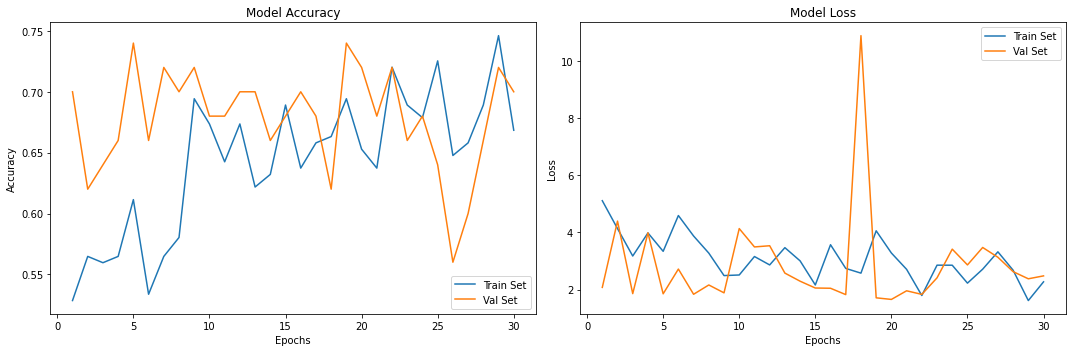

In [ ]:
# plot model performance
acc = history_dense.history['accuracy']
val_acc = history_dense.history['val_accuracy']
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']
epochs_range = range(1, len(history_dense.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# validate on val set
predictions = model_dense.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# validate on test set
predictions = model_dense.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Val Accuracy = 0.68
Test Accuracy = 0.70


# <a id='concl'>6. Applying **InceptionV3**</a>

In [ ]:
# load base model
base_model_inception = InceptionV3(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
NUM_CLASSES = 1

model_inception= Sequential()
model_inception.add(base_model_inception)
model_inception.add(layers.Flatten())
model_inception.add(layers.Dropout(0.5))
model_inception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_inception.layers[0].trainable = False

model_inception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
history_inception = model_inception.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
7/7 [==============================] - 9s 716ms/step - loss: 18.7772 - accuracy: 0.5263 - val_loss: 4.9947 - val_accuracy: 0.6600
Epoch 2/30
7/7 [==============================] - 3s 435ms/step - loss: 13.5776 - accuracy: 0.5096 - val_loss: 3.1915 - val_accuracy: 0.6800
Epoch 3/30
7/7 [==============================] - 3s 435ms/step - loss: 17.2908 - accuracy: 0.5147 - val_loss: 2.5990 - val_accuracy: 0.6600
Epoch 4/30
7/7 [==============================] - 3s 429ms/step - loss: 10.0794 - accuracy: 0.5391 - val_loss: 11.6369 - val_accuracy: 0.3800
Epoch 5/30
7/7 [==============================] - 3s 435ms/step - loss: 13.3705 - accuracy: 0.5129 - val_loss: 2.6404 - val_accuracy: 0.6800
Epoch 6/30
7/7 [==============================] - 3s 433ms/step - loss: 10.1147 - accuracy: 0.5155 - val_loss: 2.5676 - val_accuracy: 0.6400
Epoch 7/30
7/7 [==============================] - 3s 435ms/step - loss: 9.7185 - accuracy: 0.6001 - val_loss: 3.0888 - val_accuracy: 0.6800
Epoch 8/30
7/

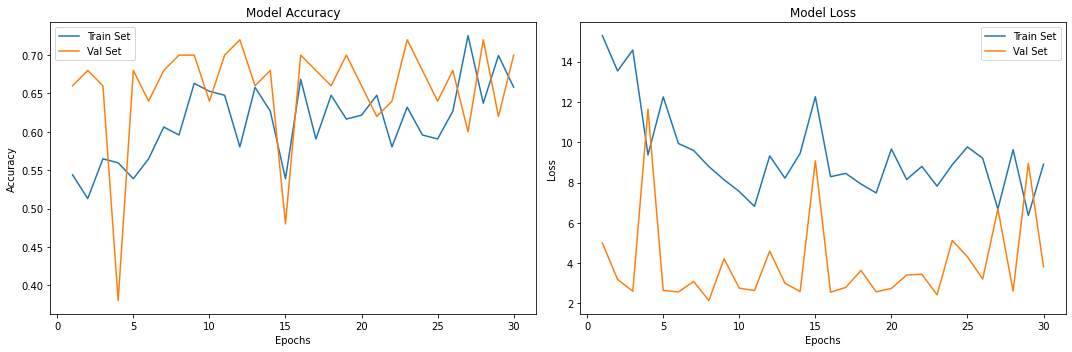

In [ ]:
# plot model performance
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs_range = range(1, len(history_inception.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# validate on val set
predictions = model_inception.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# validate on test set
predictions = model_inception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Val Accuracy = 0.66
Test Accuracy = 0.60


# <a id='concl'>7. Applying **Xception**</a>

In [49]:
# load base model
base_model_xception = Xception(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

83689472/83683744 [==============================] - 1s 0us/step


In [51]:
NUM_CLASSES = 1

model_xception= Sequential()
model_xception.add(base_model_xception)
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_xception.layers[0].trainable = False

model_xception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_xception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 100353    
Total params: 20,961,833
Trainable params: 100,353
Non-trainable params: 20,861,480
_________________________________________________________________


In [52]:
history_xception = model_xception.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
7/7 [==============================] - 7s 638ms/step - loss: 3.6032 - accuracy: 0.5559 - val_loss: 2.1477 - val_accuracy: 0.6600
Epoch 2/30
7/7 [==============================] - 3s 460ms/step - loss: 2.4393 - accuracy: 0.6302 - val_loss: 1.6751 - val_accuracy: 0.5200
Epoch 3/30
7/7 [==============================] - 3s 461ms/step - loss: 1.7163 - accuracy: 0.6656 - val_loss: 1.1899 - val_accuracy: 0.6800
Epoch 4/30
7/7 [==============================] - 3s 541ms/step - loss: 1.8361 - accuracy: 0.7348 - val_loss: 1.4564 - val_accuracy: 0.6200
Epoch 5/30
7/7 [==============================] - 3s 460ms/step - loss: 2.2543 - accuracy: 0.5887 - val_loss: 1.3970 - val_accuracy: 0.7000
Epoch 6/30
7/7 [==============================] - 3s 460ms/step - loss: 2.3084 - accuracy: 0.6867 - val_loss: 1.5202 - val_accuracy: 0.7000
Epoch 7/30
7/7 [==============================] - 3s 454ms/step - loss: 2.1983 - accuracy: 0.6076 - val_loss: 1.5064 - val_accuracy: 0.7200
Epoch 8/30
7/7 [====

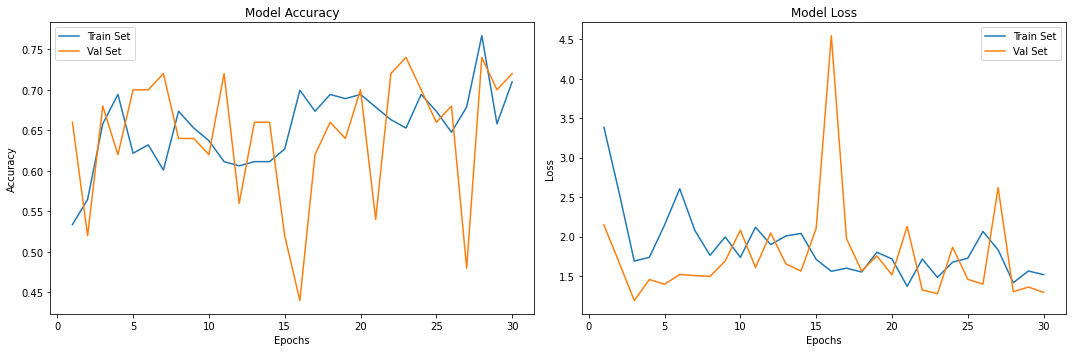

In [53]:
# plot model performance
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']
epochs_range = range(1, len(history_xception.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [54]:
# validate on val set
predictions = model_xception.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# validate on test set
predictions = model_xception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Val Accuracy = 0.72
Test Accuracy = 0.70


# <a id='concl'>8. Applying **MobileNet**</a>

In [40]:
# load base model
base_model_mobilenet = MobileNetV2(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

9412608/9406464 [==============================] - 0s 0us/step


In [41]:
NUM_CLASSES = 1

model_mobilenet= Sequential()
model_mobilenet.add(base_model_mobilenet)
model_mobilenet.add(layers.Flatten())
model_mobilenet.add(layers.Dropout(0.5))
model_mobilenet.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_mobilenet.layers[0].trainable = False

model_mobilenet.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
EPOCHS = 30
history_mobilenet = model_mobilenet.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
7/7 [==============================] - 13s 587ms/step - loss: 1.6248 - accuracy: 0.4990 - val_loss: 0.8167 - val_accuracy: 0.6800
Epoch 2/30
7/7 [==============================] - 3s 413ms/step - loss: 0.7559 - accuracy: 0.7049 - val_loss: 0.7761 - val_accuracy: 0.6400
Epoch 3/30
7/7 [==============================] - 3s 408ms/step - loss: 0.6751 - accuracy: 0.7293 - val_loss: 0.7544 - val_accuracy: 0.6600
Epoch 4/30
7/7 [==============================] - 3s 405ms/step - loss: 0.5931 - accuracy: 0.7033 - val_loss: 0.7998 - val_accuracy: 0.6600
Epoch 5/30
7/7 [==============================] - 3s 414ms/step - loss: 0.5616 - accuracy: 0.8011 - val_loss: 0.7333 - val_accuracy: 0.6800
Epoch 6/30
7/7 [==============================] - 3s 409ms/step - loss: 0.6280 - accuracy: 0.7041 - val_loss: 0.7038 - val_accuracy: 0.7200
Epoch 7/30
7/7 [==============================] - 3s 413ms/step - loss: 0.5729 - accuracy: 0.7816 - val_loss: 0.7054 - val_accuracy: 0.6600
Epoch 8/30
7/7 [===

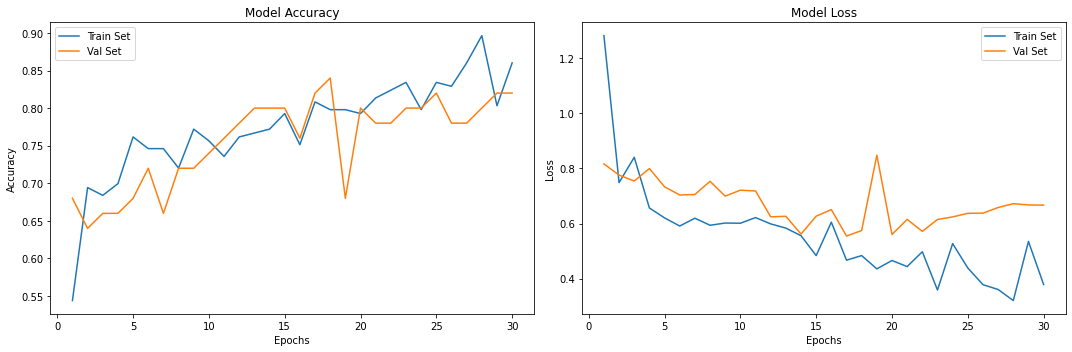

In [47]:
# plot model performance
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs_range = range(1, len(history_mobilenet.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [48]:
# validate on val set
predictions = model_mobilenet.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# validate on test set
predictions = model_mobilenet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Val Accuracy = 0.78
Test Accuracy = 1.00


Model |  Cross-val | Test
--- | --- | ---
VGG16 | 0.80 | 0.90
DenseNet201 | 0.68 | 0.70
InceptionV3 | 0.66 | 0.70
Xception | 0.72 | 0.70
MobileNet | 0.78 | 1.0